In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [9]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       1
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       1
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,1.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,-1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [10]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


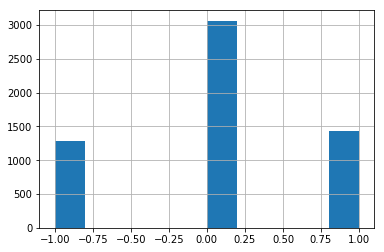

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

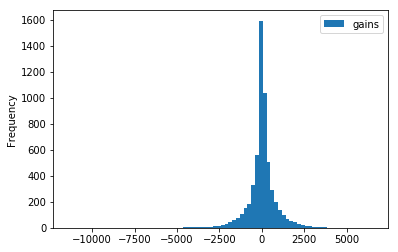

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 150
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       0
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0      -1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0


In [15]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

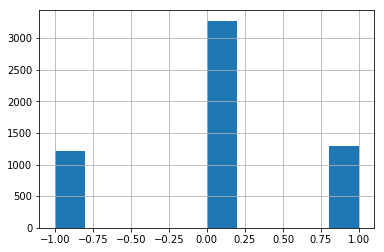

In [16]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

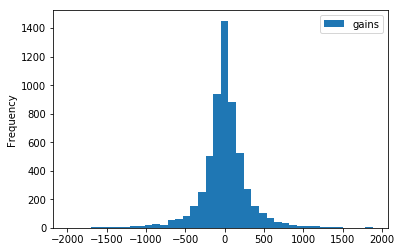

In [17]:
corn_gains[['gains']].plot.hist(bins=40)

In [18]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,-1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,1.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,0.0


In [19]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75      -1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       1
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       1
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75      -1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,1.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,1.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,-1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,1.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,1.0


In [20]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

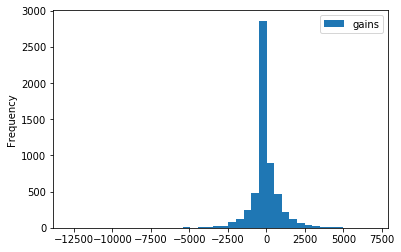

In [21]:
coffee_gains[['gains']].plot.hist(bins=40)

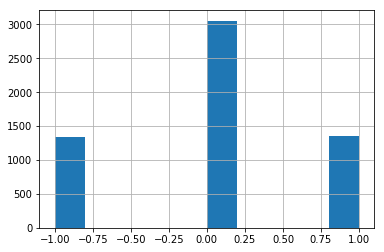

In [22]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [23]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,-1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-17,103.05,105.50,103.05,104.30,6504.0,16852.0,7.947020,1.0


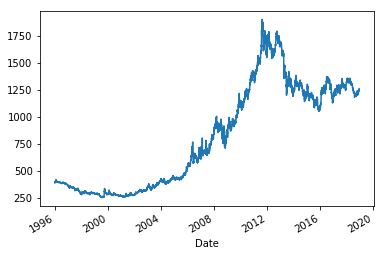

In [24]:
gold['Open'].plot()

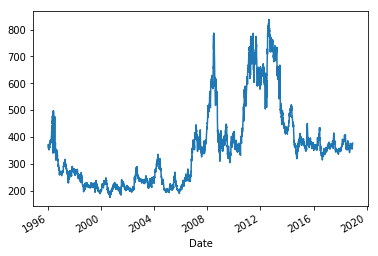

In [25]:
corn['Open'].plot()

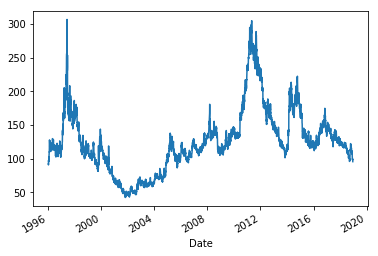

In [26]:
coffee['Open'].plot()

In [27]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    # df_train = pd.DataFrame(df_train)
    # df_test = pd.DataFrame(df_test)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)
    # return df_train[list(range(label_index))], df_train[label_index], df_validate[list(range(label_index))], df_validate[label_index], pca    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca = pd.DataFrame(df_pca, index=df.index)
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    # df_pca = pd.concat([df_pca, df[list(range(3040, label_index))]], axis=1)
    return df_pca

In [34]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
# gold_train, gold_label_train, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [35]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [36]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [37]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2007-01-02,443.3,444.0,434.4,437.0,67906.0,226150.0,436.0,439.8,434.7,438.4,...,0.531691,0.369919,0.484046,0.336928,1,2,1,0,0.000000,-1.0
2007-01-03,436.0,439.8,434.7,438.4,32949.0,217477.0,435.8,436.3,427.8,429.7,...,0.531691,0.369919,0.484046,0.336928,2,3,1,0,85.984848,0.0
2007-01-04,435.8,436.3,427.8,429.7,82846.0,208448.0,427.4,429.7,424.8,429.2,...,0.484046,0.336928,0.345193,0.474129,3,4,1,0,89.393939,-1.0
2007-01-05,427.4,429.7,424.8,429.2,54829.0,202128.0,426.3,429.3,426.1,427.3,...,0.484046,0.336928,0.345193,0.474129,4,5,1,0,96.683673,0.0
2007-01-08,426.3,429.3,426.1,427.3,43721.0,196268.0,425.7,427.0,421.1,421.6,...,0.484046,0.336928,0.345193,0.474129,0,6,1,0,94.557823,1.0
2007-01-09,425.7,427.0,421.1,421.6,65179.0,188605.0,421.2,425.8,417.1,419.5,...,0.484046,0.336928,0.345193,0.474129,1,7,1,0,89.795918,0.0
2007-01-10,421.2,425.8,417.1,419.5,97972.0,176117.0,419.7,421.3,419.5,419.7,...,0.345193,0.474129,0.801490,0.141280,2,8,1,0,91.156463,0.0
2007-01-11,419.7,421.3,419.5,419.7,34177.0,172080.0,421.3,423.3,421.1,422.4,...,0.345193,0.474129,0.801490,0.141280,3,9,1,0,90.731293,1.0
2007-01-12,421.3,423.3,421.1,422.4,46900.0,164267.0,421.7,428.3,421.1,426.6,...,0.345193,0.474129,0.801490,0.141280,4,10,1,0,79.676871,0.0
2007-01-15,421.7,428.3,421.1,426.6,64043.0,164973.0,424.1,425.5,423.6,425.1,...,0.345193,0.474129,0.801490,0.141280,0,1,1,0,10.629252,0.0


In [38]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

categoricals = [5, 6, 7, 8]
# categoricals = 'auto'
# categoricals = [3040,3041,3042,3043]
X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x < 0 else 0, gold_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, gold_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

gold_short = True

param = {'num_leaves':31, 'objective':'binary'}
param['objective'] = 'binary'
param['boosting'] = 'dart'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 50
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 3000

gold_xgb_use = False
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_error: 0.362657
[2]	valid_0's binary_error: 0.362657
[3]	valid_0's binary_error: 0.362657
[4]	valid_0's binary_error: 0.362657
[5]	valid_0's binary_error: 0.362657
[6]	valid_0's binary_error: 0.362657
[7]	valid_0's binary_error: 0.362657
[8]	valid_0's binary_error: 0.362657
[9]	valid_0's binary_error: 0.362657
[10]	valid_0's binary_error: 0.362657
[11]	valid_0's binary_error: 0.362657
[12]	valid_0's binary_error: 0.362657
[13]	valid_0's binary_error: 0.362657
[14]	valid_0's binary_error: 0.362657
[15]	valid_0's binary_error: 0.362657
[16]	valid_0's binary_error: 0.362657
[17]	valid_0's binary_error: 0.362657
[18]	valid_0's binary_error: 0.362657
[19]	valid_0's binary_error: 0.362657
[20]	valid_0's binary_error: 0.362657
[21]	valid_0's binary_error: 0.362657
[22]	valid_0's binary_error: 0.362657
[23]	valid_0's binary_error: 0.362657
[24]	valid_0's binary_error: 0.362657
[25]	valid_0's binary_error: 0.362657
[26]	valid_0's binary_error: 0.362657
[27]	valid_0's binary

[344]	valid_0's binary_error: 0.38061
[345]	valid_0's binary_error: 0.38061
[346]	valid_0's binary_error: 0.38061
[347]	valid_0's binary_error: 0.382406
[348]	valid_0's binary_error: 0.382406
[349]	valid_0's binary_error: 0.38061
[350]	valid_0's binary_error: 0.38061
[351]	valid_0's binary_error: 0.378815
[352]	valid_0's binary_error: 0.378815
[353]	valid_0's binary_error: 0.38061
[354]	valid_0's binary_error: 0.38061
[355]	valid_0's binary_error: 0.382406
[356]	valid_0's binary_error: 0.38061
[357]	valid_0's binary_error: 0.38061
[358]	valid_0's binary_error: 0.38061
[359]	valid_0's binary_error: 0.38061
[360]	valid_0's binary_error: 0.38061
[361]	valid_0's binary_error: 0.38061
[362]	valid_0's binary_error: 0.382406
[363]	valid_0's binary_error: 0.382406
[364]	valid_0's binary_error: 0.382406
[365]	valid_0's binary_error: 0.382406
[366]	valid_0's binary_error: 0.382406
[367]	valid_0's binary_error: 0.38061
[368]	valid_0's binary_error: 0.38061
[369]	valid_0's binary_error: 0.382406
[

[602]	valid_0's binary_error: 0.396768
[603]	valid_0's binary_error: 0.398564
[604]	valid_0's binary_error: 0.398564
[605]	valid_0's binary_error: 0.398564
[606]	valid_0's binary_error: 0.398564
[607]	valid_0's binary_error: 0.398564
[608]	valid_0's binary_error: 0.398564
[609]	valid_0's binary_error: 0.400359
[610]	valid_0's binary_error: 0.398564
[611]	valid_0's binary_error: 0.396768
[612]	valid_0's binary_error: 0.398564
[613]	valid_0's binary_error: 0.398564
[614]	valid_0's binary_error: 0.398564
[615]	valid_0's binary_error: 0.396768
[616]	valid_0's binary_error: 0.398564
[617]	valid_0's binary_error: 0.398564
[618]	valid_0's binary_error: 0.396768
[619]	valid_0's binary_error: 0.398564
[620]	valid_0's binary_error: 0.396768
[621]	valid_0's binary_error: 0.396768
[622]	valid_0's binary_error: 0.396768
[623]	valid_0's binary_error: 0.396768
[624]	valid_0's binary_error: 0.396768
[625]	valid_0's binary_error: 0.400359
[626]	valid_0's binary_error: 0.400359
[627]	valid_0's binary_er

[838]	valid_0's binary_error: 0.394973
[839]	valid_0's binary_error: 0.391382
[840]	valid_0's binary_error: 0.389587
[841]	valid_0's binary_error: 0.393178
[842]	valid_0's binary_error: 0.393178
[843]	valid_0's binary_error: 0.393178
[844]	valid_0's binary_error: 0.393178
[845]	valid_0's binary_error: 0.393178
[846]	valid_0's binary_error: 0.393178
[847]	valid_0's binary_error: 0.394973
[848]	valid_0's binary_error: 0.394973
[849]	valid_0's binary_error: 0.394973
[850]	valid_0's binary_error: 0.396768
[851]	valid_0's binary_error: 0.396768
[852]	valid_0's binary_error: 0.396768
[853]	valid_0's binary_error: 0.396768
[854]	valid_0's binary_error: 0.396768
[855]	valid_0's binary_error: 0.394973
[856]	valid_0's binary_error: 0.394973
[857]	valid_0's binary_error: 0.394973
[858]	valid_0's binary_error: 0.393178
[859]	valid_0's binary_error: 0.393178
[860]	valid_0's binary_error: 0.396768
[861]	valid_0's binary_error: 0.396768
[862]	valid_0's binary_error: 0.396768
[863]	valid_0's binary_er

[1049]	valid_0's binary_error: 0.400359
[1050]	valid_0's binary_error: 0.400359
[1051]	valid_0's binary_error: 0.400359
[1052]	valid_0's binary_error: 0.400359
[1053]	valid_0's binary_error: 0.400359
[1054]	valid_0's binary_error: 0.400359
[1055]	valid_0's binary_error: 0.400359
[1056]	valid_0's binary_error: 0.402154
[1057]	valid_0's binary_error: 0.402154
[1058]	valid_0's binary_error: 0.402154
[1059]	valid_0's binary_error: 0.402154
[1060]	valid_0's binary_error: 0.402154
[1061]	valid_0's binary_error: 0.402154
[1062]	valid_0's binary_error: 0.402154
[1063]	valid_0's binary_error: 0.402154
[1064]	valid_0's binary_error: 0.402154
[1065]	valid_0's binary_error: 0.402154
[1066]	valid_0's binary_error: 0.40395
[1067]	valid_0's binary_error: 0.402154
[1068]	valid_0's binary_error: 0.40395
[1069]	valid_0's binary_error: 0.40395
[1070]	valid_0's binary_error: 0.402154
[1071]	valid_0's binary_error: 0.400359
[1072]	valid_0's binary_error: 0.400359
[1073]	valid_0's binary_error: 0.402154
[10

[1313]	valid_0's binary_error: 0.40395
[1314]	valid_0's binary_error: 0.40395
[1315]	valid_0's binary_error: 0.40395
[1316]	valid_0's binary_error: 0.40395
[1317]	valid_0's binary_error: 0.40395
[1318]	valid_0's binary_error: 0.40395
[1319]	valid_0's binary_error: 0.405745
[1320]	valid_0's binary_error: 0.405745
[1321]	valid_0's binary_error: 0.405745
[1322]	valid_0's binary_error: 0.40395
[1323]	valid_0's binary_error: 0.40395
[1324]	valid_0's binary_error: 0.40395
[1325]	valid_0's binary_error: 0.405745
[1326]	valid_0's binary_error: 0.402154
[1327]	valid_0's binary_error: 0.402154
[1328]	valid_0's binary_error: 0.402154
[1329]	valid_0's binary_error: 0.40395
[1330]	valid_0's binary_error: 0.40395
[1331]	valid_0's binary_error: 0.402154
[1332]	valid_0's binary_error: 0.402154
[1333]	valid_0's binary_error: 0.40395
[1334]	valid_0's binary_error: 0.402154
[1335]	valid_0's binary_error: 0.402154
[1336]	valid_0's binary_error: 0.402154
[1337]	valid_0's binary_error: 0.402154
[1338]	valid

[1531]	valid_0's binary_error: 0.421903
[1532]	valid_0's binary_error: 0.421903
[1533]	valid_0's binary_error: 0.421903
[1534]	valid_0's binary_error: 0.421903
[1535]	valid_0's binary_error: 0.423698
[1536]	valid_0's binary_error: 0.425494
[1537]	valid_0's binary_error: 0.423698
[1538]	valid_0's binary_error: 0.423698
[1539]	valid_0's binary_error: 0.421903
[1540]	valid_0's binary_error: 0.421903
[1541]	valid_0's binary_error: 0.423698
[1542]	valid_0's binary_error: 0.423698
[1543]	valid_0's binary_error: 0.425494
[1544]	valid_0's binary_error: 0.425494
[1545]	valid_0's binary_error: 0.425494
[1546]	valid_0's binary_error: 0.425494
[1547]	valid_0's binary_error: 0.425494
[1548]	valid_0's binary_error: 0.421903
[1549]	valid_0's binary_error: 0.421903
[1550]	valid_0's binary_error: 0.425494
[1551]	valid_0's binary_error: 0.423698
[1552]	valid_0's binary_error: 0.423698
[1553]	valid_0's binary_error: 0.423698
[1554]	valid_0's binary_error: 0.423698
[1555]	valid_0's binary_error: 0.423698


[1782]	valid_0's binary_error: 0.420108
[1783]	valid_0's binary_error: 0.421903
[1784]	valid_0's binary_error: 0.420108
[1785]	valid_0's binary_error: 0.420108
[1786]	valid_0's binary_error: 0.420108
[1787]	valid_0's binary_error: 0.420108
[1788]	valid_0's binary_error: 0.418312
[1789]	valid_0's binary_error: 0.418312
[1790]	valid_0's binary_error: 0.418312
[1791]	valid_0's binary_error: 0.418312
[1792]	valid_0's binary_error: 0.420108
[1793]	valid_0's binary_error: 0.420108
[1794]	valid_0's binary_error: 0.420108
[1795]	valid_0's binary_error: 0.420108
[1796]	valid_0's binary_error: 0.420108
[1797]	valid_0's binary_error: 0.420108
[1798]	valid_0's binary_error: 0.420108
[1799]	valid_0's binary_error: 0.420108
[1800]	valid_0's binary_error: 0.420108
[1801]	valid_0's binary_error: 0.420108
[1802]	valid_0's binary_error: 0.418312
[1803]	valid_0's binary_error: 0.418312
[1804]	valid_0's binary_error: 0.418312
[1805]	valid_0's binary_error: 0.418312
[1806]	valid_0's binary_error: 0.418312


[1996]	valid_0's binary_error: 0.412926
[1997]	valid_0's binary_error: 0.412926
[1998]	valid_0's binary_error: 0.412926
[1999]	valid_0's binary_error: 0.412926
[2000]	valid_0's binary_error: 0.412926
[2001]	valid_0's binary_error: 0.412926
[2002]	valid_0's binary_error: 0.412926
[2003]	valid_0's binary_error: 0.412926
[2004]	valid_0's binary_error: 0.416517
[2005]	valid_0's binary_error: 0.416517
[2006]	valid_0's binary_error: 0.416517
[2007]	valid_0's binary_error: 0.414722
[2008]	valid_0's binary_error: 0.414722
[2009]	valid_0's binary_error: 0.414722
[2010]	valid_0's binary_error: 0.414722
[2011]	valid_0's binary_error: 0.414722
[2012]	valid_0's binary_error: 0.414722
[2013]	valid_0's binary_error: 0.414722
[2014]	valid_0's binary_error: 0.418312
[2015]	valid_0's binary_error: 0.420108
[2016]	valid_0's binary_error: 0.418312
[2017]	valid_0's binary_error: 0.418312
[2018]	valid_0's binary_error: 0.421903
[2019]	valid_0's binary_error: 0.420108
[2020]	valid_0's binary_error: 0.418312


[2213]	valid_0's binary_error: 0.427289
[2214]	valid_0's binary_error: 0.427289
[2215]	valid_0's binary_error: 0.427289
[2216]	valid_0's binary_error: 0.427289
[2217]	valid_0's binary_error: 0.427289
[2218]	valid_0's binary_error: 0.427289
[2219]	valid_0's binary_error: 0.427289
[2220]	valid_0's binary_error: 0.429084
[2221]	valid_0's binary_error: 0.429084
[2222]	valid_0's binary_error: 0.429084
[2223]	valid_0's binary_error: 0.429084
[2224]	valid_0's binary_error: 0.43088
[2225]	valid_0's binary_error: 0.43088
[2226]	valid_0's binary_error: 0.43088
[2227]	valid_0's binary_error: 0.429084
[2228]	valid_0's binary_error: 0.429084
[2229]	valid_0's binary_error: 0.429084
[2230]	valid_0's binary_error: 0.427289
[2231]	valid_0's binary_error: 0.429084
[2232]	valid_0's binary_error: 0.429084
[2233]	valid_0's binary_error: 0.429084
[2234]	valid_0's binary_error: 0.429084
[2235]	valid_0's binary_error: 0.43088
[2236]	valid_0's binary_error: 0.43088
[2237]	valid_0's binary_error: 0.432675
[2238

[2433]	valid_0's binary_error: 0.427289
[2434]	valid_0's binary_error: 0.427289
[2435]	valid_0's binary_error: 0.427289
[2436]	valid_0's binary_error: 0.427289
[2437]	valid_0's binary_error: 0.427289
[2438]	valid_0's binary_error: 0.427289
[2439]	valid_0's binary_error: 0.427289
[2440]	valid_0's binary_error: 0.423698
[2441]	valid_0's binary_error: 0.423698
[2442]	valid_0's binary_error: 0.423698
[2443]	valid_0's binary_error: 0.425494
[2444]	valid_0's binary_error: 0.425494
[2445]	valid_0's binary_error: 0.425494
[2446]	valid_0's binary_error: 0.425494
[2447]	valid_0's binary_error: 0.425494
[2448]	valid_0's binary_error: 0.425494
[2449]	valid_0's binary_error: 0.425494
[2450]	valid_0's binary_error: 0.425494
[2451]	valid_0's binary_error: 0.423698
[2452]	valid_0's binary_error: 0.423698
[2453]	valid_0's binary_error: 0.423698
[2454]	valid_0's binary_error: 0.423698
[2455]	valid_0's binary_error: 0.423698
[2456]	valid_0's binary_error: 0.423698
[2457]	valid_0's binary_error: 0.423698


[2724]	valid_0's binary_error: 0.420108
[2725]	valid_0's binary_error: 0.420108
[2726]	valid_0's binary_error: 0.420108
[2727]	valid_0's binary_error: 0.420108
[2728]	valid_0's binary_error: 0.420108
[2729]	valid_0's binary_error: 0.421903
[2730]	valid_0's binary_error: 0.423698
[2731]	valid_0's binary_error: 0.423698
[2732]	valid_0's binary_error: 0.423698
[2733]	valid_0's binary_error: 0.423698
[2734]	valid_0's binary_error: 0.423698
[2735]	valid_0's binary_error: 0.423698
[2736]	valid_0's binary_error: 0.421903
[2737]	valid_0's binary_error: 0.421903
[2738]	valid_0's binary_error: 0.421903
[2739]	valid_0's binary_error: 0.421903
[2740]	valid_0's binary_error: 0.421903
[2741]	valid_0's binary_error: 0.421903
[2742]	valid_0's binary_error: 0.421903
[2743]	valid_0's binary_error: 0.421903
[2744]	valid_0's binary_error: 0.421903
[2745]	valid_0's binary_error: 0.421903
[2746]	valid_0's binary_error: 0.421903
[2747]	valid_0's binary_error: 0.421903
[2748]	valid_0's binary_error: 0.421903


[2951]	valid_0's binary_error: 0.432675
[2952]	valid_0's binary_error: 0.432675
[2953]	valid_0's binary_error: 0.432675
[2954]	valid_0's binary_error: 0.432675
[2955]	valid_0's binary_error: 0.43447
[2956]	valid_0's binary_error: 0.432675
[2957]	valid_0's binary_error: 0.43088
[2958]	valid_0's binary_error: 0.43088
[2959]	valid_0's binary_error: 0.43088
[2960]	valid_0's binary_error: 0.432675
[2961]	valid_0's binary_error: 0.432675
[2962]	valid_0's binary_error: 0.432675
[2963]	valid_0's binary_error: 0.432675
[2964]	valid_0's binary_error: 0.432675
[2965]	valid_0's binary_error: 0.432675
[2966]	valid_0's binary_error: 0.432675
[2967]	valid_0's binary_error: 0.432675
[2968]	valid_0's binary_error: 0.432675
[2969]	valid_0's binary_error: 0.432675
[2970]	valid_0's binary_error: 0.432675
[2971]	valid_0's binary_error: 0.432675
[2972]	valid_0's binary_error: 0.432675
[2973]	valid_0's binary_error: 0.432675
[2974]	valid_0's binary_error: 0.43088
[2975]	valid_0's binary_error: 0.43088
[2976]

In [39]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: 1 if x < 0 else 0, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_short = True
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [40]:
%%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_test)), categorical_feature='auto')
coffee_short = True
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [228]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, short=False, multi_class=False, stop_loss=500, vector=False):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if short:
        target = -1
    else:
        target = 1
    preds = model.predict(df)
    if vector:
        preds = [p[0] for p in preds]
    predictions = []
    if not multi_class:
        mx = 0
        for p in preds:
            if p > mx:
                print(mx)
                mx = p
            if p > 0.5:
                predictions.append(target)
            else:
                predictions.append(0)
    else:
        mx = 0
        for t, n in preds:
            if t > mx:
                print(mx)
                mx = t
            if t > 0.5:
                predictions.append(target)
            else:
                predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

0
0.3627387648008152
0.7379977810282158
0.7987783941545523


(0, 18000)

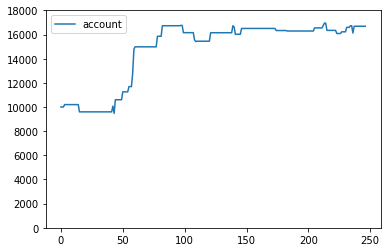

In [229]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=gold_short, stop_loss=600)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0da7cefd68>,
      dtype=object)

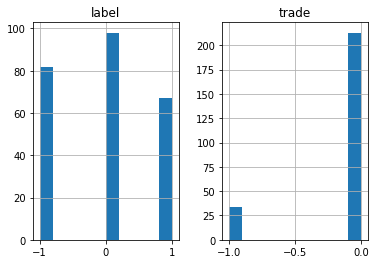

In [210]:
gold_account[['trade', 'label']].hist()

In [211]:
gold_account[gold_account['short'] == 1].gains.sum()

6684.5

In [212]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

0
0.24864967440974384
0.25926906051143034
0.2955660888615423
0.2977100239504101
0.30830693719189034
0.4147514460746971
0.4487667667636265
0.48411973419097115
0.5039178540041541
0.524897915158871
0.5936756203002241
0.6166601340814227
0.6447360073366751
0.6960664263279063
0.7225563537098175
0.7556325901019348


(0, 14000)

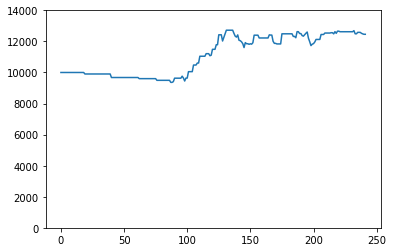

In [226]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=True, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,14000)

In [227]:
corn_account[corn_account['short'] == 1].gains.sum()

2459.25

In [215]:
corn_account[corn_account['long'] == 1].gains.sum()

-2337.125

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0db12e96a0>,
      dtype=object)

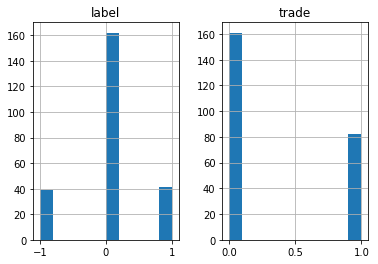

In [216]:
corn_account[['trade', 'label']].hist()

0
0.4378020290639108
0.4395958126356814
0.4412707855178105
0.443435551019472
0.4501743345654289
0.45077293522262396
0.4841600503459057
0.5128072119976873
0.5388536022380092
0.5547294547376576
0.5736435119648495
0.5789063083367268
0.582139731822411


(0, 19000)

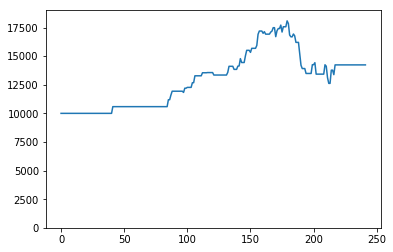

In [217]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,19000)

In [218]:
coffee_account[coffee_account['short'] == 1].gains.sum()

4234.937500000002

In [219]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0da7a79f28>,
      dtype=object)

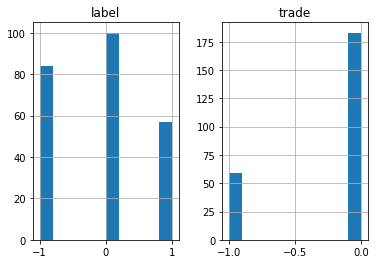

In [220]:
coffee_account[['trade', 'label']].hist()

In [221]:
# %%capture gold_long_train
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

# categoricals = [5, 6, 7, 8]
X = pca_transform(gold_train, gold_pca)
# print(X[0])
# enc = OneHotEncoder(handle_unknown='ignore', categorical_features=categoricals)
# enc = OneHotEncoder()
# print(OneHotEncoder(X[:,5]))
# print(type(X))
# X = enc.fit_transform(X[:,5:9])
# print(X[0])
y = list(map(lambda x: 1 if x > 0 else 0, gold_label_train))
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x > 0 else 0, gold_label_test))
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

# param = {'num_leaves':31, 'objective':'binary'}
# param['objective'] = 'binary'
# param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['learning_rate'] = 0.05
# param['num_class'] = 1
# param['max_bin'] = 30
# param['reg_alpha'] = 5
# param['reg_lambda'] = 10
# num_round = 3000

# gold_short = False
# gold_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# gold_clf_long = RandomForestClassifier(n_estimators=200)
gold_clf_long = MLPClassifier(solver='lbfgs', alpha=1e-2,
                              hidden_layer_sizes=(10, 20, 2), random_state=55431)
gold_clf_long.fit(np.concatenate([X, X_test]), np.concatenate([y, y_test]))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=55431, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [231]:
%%capture training_gold
# from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

X_train = np.concatenate([X, X_test])
# print(np.concatenate([y, y_test]).sum())
# y_train = np.array([[1,0] if i==1 else [0,1] for i in np.concatenate([y, y_test])])
y_train = np.concatenate([y, y_test])
# print(y_train[:5])

input_shape = (10, )
num_classes = 1

# Define a model
model = Sequential()

model = Sequential()
model.add(Dense(500, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50)

model.summary()

In [232]:
gold_clf_long = model

0
0.24591473
0.3839733
0.4146538
0.42328343
0.94091994
0.9964328


(0, 18000)

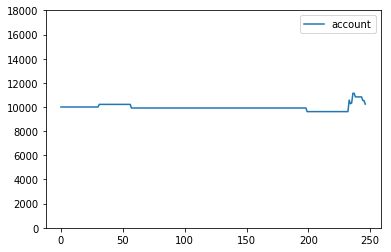

In [233]:
gold_account_long = get_performance(gold_clf_long, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=False, stop_loss=300, multi_class=False, vector=True)
ax1 = gold_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [234]:
gold_account_long[gold_account_long['long'] == 1].gains.sum()

236.4999999999783

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0da7292a20>,
      dtype=object)

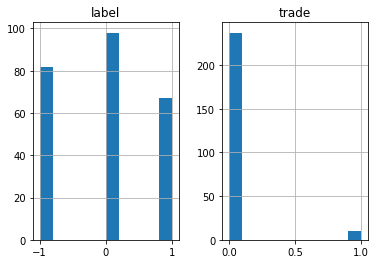

In [235]:
gold_account_long[['trade', 'label']].hist()

In [238]:
# %%capture cpt_corn_train
# X = pca_transform(corn_train, corn_pca)

# y = list(map(lambda x: 1 if x > 0 else 0, corn_label_train))
# train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
# X_test = pca_transform(corn_test, corn_pca)
# y_test = list(map(lambda x: 1 if x > 0 else 0, corn_label_test))
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
# param['max_bin'] = 10
# corn_short = False
# corn_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])
X_train = np.concatenate([X, X_test])
y_train = np.concatenate([y, y_test])

model = Sequential()

model = Sequential()
model.add(Dense(500, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50)

corn_clf_long = model

Epoch 1/50
2782/2782 [==============================] - 1s 236us/step - loss: 0.3134
Epoch 2/50
2782/2782 [==============================] - 0s 51us/step - loss: 0.3026
Epoch 3/50
2782/2782 [==============================] - 0s 52us/step - loss: 0.2701
Epoch 4/50
2782/2782 [==============================] - 0s 50us/step - loss: 0.2619
Epoch 5/50
2782/2782 [==============================] - 0s 52us/step - loss: 0.2509
Epoch 6/50
2782/2782 [==============================] - 0s 53us/step - loss: 0.2498
Epoch 7/50
2782/2782 [==============================] - 0s 50us/step - loss: 0.2403
Epoch 8/50
2782/2782 [==============================] - 0s 50us/step - loss: 0.2370
Epoch 9/50
2782/2782 [==============================] - 0s 50us/step - loss: 0.2378
Epoch 10/50
2782/2782 [==============================] - 0s 49us/step - loss: 0.2373
Epoch 11/50
2782/2782 [==============================] - 0s 49us/step - loss: 0.2372
Epoch 12/50
2782/2782 [==============================] - 0s 49us/step - l

0
[0.5070285]
[0.5599767]
[0.56211853]
[0.6256404]
[0.8285787]
[0.9381672]
[0.9688338]


(0, 18000)

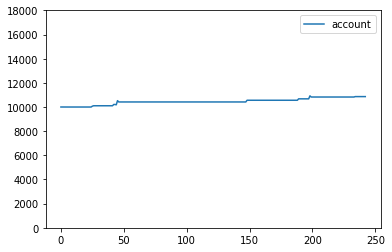

In [239]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=corn_short, stop_loss=500)
ax1 = corn_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [240]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

860.7499999999999

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0da644b5f8>,
      dtype=object)

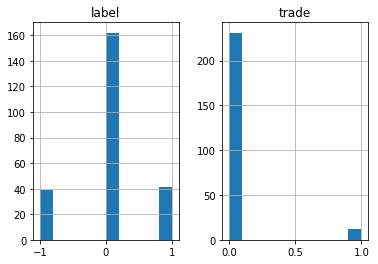

In [241]:
corn_account_long[['trade', 'label']].hist()

In [510]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_test)), categorical_feature='auto')
coffee_short = False
coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's binary_error: 0.351986
[2]	valid_0's binary_error: 0.351986
[3]	valid_0's binary_error: 0.351986
[4]	valid_0's binary_error: 0.351986
[5]	valid_0's binary_error: 0.351986
[6]	valid_0's binary_error: 0.351986
[7]	valid_0's binary_error: 0.351986
[8]	valid_0's binary_error: 0.351986
[9]	valid_0's binary_error: 0.351986
[10]	valid_0's binary_error: 0.351986
[11]	valid_0's binary_error: 0.351986
[12]	valid_0's binary_error: 0.351986
[13]	valid_0's binary_error: 0.351986
[14]	valid_0's binary_error: 0.351986
[15]	valid_0's binary_error: 0.351986
[16]	valid_0's binary_error: 0.351986
[17]	valid_0's binary_error: 0.351986
[18]	valid_0's binary_error: 0.351986
[19]	valid_0's binary_error: 0.351986
[20]	valid_0's binary_error: 0.351986
[21]	valid_0's binary_error: 0.351986
[22]	valid_0's binary_error: 0.351986
[23]	valid_0's binary_error: 0.351986
[24]	valid_0's binary_error: 0.351986
[25]	valid_0's binary_error: 0.351986
[26]	valid_0's binary_error: 0.351986
[27]	valid_0's binary

[297]	valid_0's binary_error: 0.351986
[298]	valid_0's binary_error: 0.351986
[299]	valid_0's binary_error: 0.351986
[300]	valid_0's binary_error: 0.351986
[301]	valid_0's binary_error: 0.351986
[302]	valid_0's binary_error: 0.351986
[303]	valid_0's binary_error: 0.351986
[304]	valid_0's binary_error: 0.351986
[305]	valid_0's binary_error: 0.351986
[306]	valid_0's binary_error: 0.351986
[307]	valid_0's binary_error: 0.351986
[308]	valid_0's binary_error: 0.351986
[309]	valid_0's binary_error: 0.351986
[310]	valid_0's binary_error: 0.351986
[311]	valid_0's binary_error: 0.351986
[312]	valid_0's binary_error: 0.351986
[313]	valid_0's binary_error: 0.351986
[314]	valid_0's binary_error: 0.351986
[315]	valid_0's binary_error: 0.351986
[316]	valid_0's binary_error: 0.351986
[317]	valid_0's binary_error: 0.351986
[318]	valid_0's binary_error: 0.351986
[319]	valid_0's binary_error: 0.351986
[320]	valid_0's binary_error: 0.351986
[321]	valid_0's binary_error: 0.351986
[322]	valid_0's binary_er

[562]	valid_0's binary_error: 0.351986
[563]	valid_0's binary_error: 0.351986
[564]	valid_0's binary_error: 0.351986
[565]	valid_0's binary_error: 0.351986
[566]	valid_0's binary_error: 0.351986
[567]	valid_0's binary_error: 0.351986
[568]	valid_0's binary_error: 0.351986
[569]	valid_0's binary_error: 0.351986
[570]	valid_0's binary_error: 0.351986
[571]	valid_0's binary_error: 0.351986
[572]	valid_0's binary_error: 0.351986
[573]	valid_0's binary_error: 0.351986
[574]	valid_0's binary_error: 0.351986
[575]	valid_0's binary_error: 0.351986
[576]	valid_0's binary_error: 0.351986
[577]	valid_0's binary_error: 0.351986
[578]	valid_0's binary_error: 0.351986
[579]	valid_0's binary_error: 0.351986
[580]	valid_0's binary_error: 0.351986
[581]	valid_0's binary_error: 0.351986
[582]	valid_0's binary_error: 0.351986
[583]	valid_0's binary_error: 0.351986
[584]	valid_0's binary_error: 0.351986
[585]	valid_0's binary_error: 0.351986
[586]	valid_0's binary_error: 0.351986
[587]	valid_0's binary_er

[888]	valid_0's binary_error: 0.351986
[889]	valid_0's binary_error: 0.351986
[890]	valid_0's binary_error: 0.351986
[891]	valid_0's binary_error: 0.351986
[892]	valid_0's binary_error: 0.351986
[893]	valid_0's binary_error: 0.351986
[894]	valid_0's binary_error: 0.351986
[895]	valid_0's binary_error: 0.351986
[896]	valid_0's binary_error: 0.351986
[897]	valid_0's binary_error: 0.351986
[898]	valid_0's binary_error: 0.351986
[899]	valid_0's binary_error: 0.351986
[900]	valid_0's binary_error: 0.351986
[901]	valid_0's binary_error: 0.351986
[902]	valid_0's binary_error: 0.351986
[903]	valid_0's binary_error: 0.351986
[904]	valid_0's binary_error: 0.351986
[905]	valid_0's binary_error: 0.351986
[906]	valid_0's binary_error: 0.351986
[907]	valid_0's binary_error: 0.351986
[908]	valid_0's binary_error: 0.351986
[909]	valid_0's binary_error: 0.351986
[910]	valid_0's binary_error: 0.351986
[911]	valid_0's binary_error: 0.351986
[912]	valid_0's binary_error: 0.351986
[913]	valid_0's binary_er

[1110]	valid_0's binary_error: 0.351986
[1111]	valid_0's binary_error: 0.351986
[1112]	valid_0's binary_error: 0.351986
[1113]	valid_0's binary_error: 0.351986
[1114]	valid_0's binary_error: 0.351986
[1115]	valid_0's binary_error: 0.351986
[1116]	valid_0's binary_error: 0.351986
[1117]	valid_0's binary_error: 0.351986
[1118]	valid_0's binary_error: 0.351986
[1119]	valid_0's binary_error: 0.351986
[1120]	valid_0's binary_error: 0.351986
[1121]	valid_0's binary_error: 0.351986
[1122]	valid_0's binary_error: 0.351986
[1123]	valid_0's binary_error: 0.351986
[1124]	valid_0's binary_error: 0.351986
[1125]	valid_0's binary_error: 0.351986
[1126]	valid_0's binary_error: 0.351986
[1127]	valid_0's binary_error: 0.351986
[1128]	valid_0's binary_error: 0.351986
[1129]	valid_0's binary_error: 0.351986
[1130]	valid_0's binary_error: 0.351986
[1131]	valid_0's binary_error: 0.351986
[1132]	valid_0's binary_error: 0.351986
[1133]	valid_0's binary_error: 0.351986
[1134]	valid_0's binary_error: 0.351986


[1336]	valid_0's binary_error: 0.351986
[1337]	valid_0's binary_error: 0.351986
[1338]	valid_0's binary_error: 0.351986
[1339]	valid_0's binary_error: 0.351986
[1340]	valid_0's binary_error: 0.351986
[1341]	valid_0's binary_error: 0.351986
[1342]	valid_0's binary_error: 0.351986
[1343]	valid_0's binary_error: 0.351986
[1344]	valid_0's binary_error: 0.351986
[1345]	valid_0's binary_error: 0.351986
[1346]	valid_0's binary_error: 0.351986
[1347]	valid_0's binary_error: 0.351986
[1348]	valid_0's binary_error: 0.351986
[1349]	valid_0's binary_error: 0.351986
[1350]	valid_0's binary_error: 0.351986
[1351]	valid_0's binary_error: 0.351986
[1352]	valid_0's binary_error: 0.351986
[1353]	valid_0's binary_error: 0.351986
[1354]	valid_0's binary_error: 0.351986
[1355]	valid_0's binary_error: 0.351986
[1356]	valid_0's binary_error: 0.351986
[1357]	valid_0's binary_error: 0.351986
[1358]	valid_0's binary_error: 0.351986
[1359]	valid_0's binary_error: 0.351986
[1360]	valid_0's binary_error: 0.351986


[1576]	valid_0's binary_error: 0.355596
[1577]	valid_0's binary_error: 0.355596
[1578]	valid_0's binary_error: 0.355596
[1579]	valid_0's binary_error: 0.355596
[1580]	valid_0's binary_error: 0.355596
[1581]	valid_0's binary_error: 0.355596
[1582]	valid_0's binary_error: 0.355596
[1583]	valid_0's binary_error: 0.355596
[1584]	valid_0's binary_error: 0.355596
[1585]	valid_0's binary_error: 0.355596
[1586]	valid_0's binary_error: 0.355596
[1587]	valid_0's binary_error: 0.355596
[1588]	valid_0's binary_error: 0.355596
[1589]	valid_0's binary_error: 0.355596
[1590]	valid_0's binary_error: 0.353791
[1591]	valid_0's binary_error: 0.355596
[1592]	valid_0's binary_error: 0.355596
[1593]	valid_0's binary_error: 0.355596
[1594]	valid_0's binary_error: 0.355596
[1595]	valid_0's binary_error: 0.355596
[1596]	valid_0's binary_error: 0.355596
[1597]	valid_0's binary_error: 0.355596
[1598]	valid_0's binary_error: 0.355596
[1599]	valid_0's binary_error: 0.355596
[1600]	valid_0's binary_error: 0.355596


[1800]	valid_0's binary_error: 0.351986
[1801]	valid_0's binary_error: 0.351986
[1802]	valid_0's binary_error: 0.351986
[1803]	valid_0's binary_error: 0.351986
[1804]	valid_0's binary_error: 0.351986
[1805]	valid_0's binary_error: 0.351986
[1806]	valid_0's binary_error: 0.351986
[1807]	valid_0's binary_error: 0.351986
[1808]	valid_0's binary_error: 0.351986
[1809]	valid_0's binary_error: 0.351986
[1810]	valid_0's binary_error: 0.351986
[1811]	valid_0's binary_error: 0.351986
[1812]	valid_0's binary_error: 0.351986
[1813]	valid_0's binary_error: 0.351986
[1814]	valid_0's binary_error: 0.351986
[1815]	valid_0's binary_error: 0.351986
[1816]	valid_0's binary_error: 0.351986
[1817]	valid_0's binary_error: 0.351986
[1818]	valid_0's binary_error: 0.351986
[1819]	valid_0's binary_error: 0.351986
[1820]	valid_0's binary_error: 0.351986
[1821]	valid_0's binary_error: 0.351986
[1822]	valid_0's binary_error: 0.351986
[1823]	valid_0's binary_error: 0.351986
[1824]	valid_0's binary_error: 0.351986


[2058]	valid_0's binary_error: 0.351986
[2059]	valid_0's binary_error: 0.351986
[2060]	valid_0's binary_error: 0.351986
[2061]	valid_0's binary_error: 0.351986
[2062]	valid_0's binary_error: 0.351986
[2063]	valid_0's binary_error: 0.351986
[2064]	valid_0's binary_error: 0.351986
[2065]	valid_0's binary_error: 0.351986
[2066]	valid_0's binary_error: 0.351986
[2067]	valid_0's binary_error: 0.351986
[2068]	valid_0's binary_error: 0.351986
[2069]	valid_0's binary_error: 0.351986
[2070]	valid_0's binary_error: 0.351986
[2071]	valid_0's binary_error: 0.351986
[2072]	valid_0's binary_error: 0.351986
[2073]	valid_0's binary_error: 0.351986
[2074]	valid_0's binary_error: 0.351986
[2075]	valid_0's binary_error: 0.351986
[2076]	valid_0's binary_error: 0.351986
[2077]	valid_0's binary_error: 0.351986
[2078]	valid_0's binary_error: 0.351986
[2079]	valid_0's binary_error: 0.351986
[2080]	valid_0's binary_error: 0.351986
[2081]	valid_0's binary_error: 0.351986
[2082]	valid_0's binary_error: 0.351986


[2312]	valid_0's binary_error: 0.353791
[2313]	valid_0's binary_error: 0.353791
[2314]	valid_0's binary_error: 0.353791
[2315]	valid_0's binary_error: 0.353791
[2316]	valid_0's binary_error: 0.353791
[2317]	valid_0's binary_error: 0.353791
[2318]	valid_0's binary_error: 0.353791
[2319]	valid_0's binary_error: 0.353791
[2320]	valid_0's binary_error: 0.353791
[2321]	valid_0's binary_error: 0.353791
[2322]	valid_0's binary_error: 0.353791
[2323]	valid_0's binary_error: 0.353791
[2324]	valid_0's binary_error: 0.353791
[2325]	valid_0's binary_error: 0.353791
[2326]	valid_0's binary_error: 0.353791
[2327]	valid_0's binary_error: 0.353791
[2328]	valid_0's binary_error: 0.353791
[2329]	valid_0's binary_error: 0.353791
[2330]	valid_0's binary_error: 0.353791
[2331]	valid_0's binary_error: 0.353791
[2332]	valid_0's binary_error: 0.353791
[2333]	valid_0's binary_error: 0.353791
[2334]	valid_0's binary_error: 0.353791
[2335]	valid_0's binary_error: 0.353791
[2336]	valid_0's binary_error: 0.353791


[2581]	valid_0's binary_error: 0.353791
[2582]	valid_0's binary_error: 0.353791
[2583]	valid_0's binary_error: 0.353791
[2584]	valid_0's binary_error: 0.353791
[2585]	valid_0's binary_error: 0.353791
[2586]	valid_0's binary_error: 0.353791
[2587]	valid_0's binary_error: 0.353791
[2588]	valid_0's binary_error: 0.353791
[2589]	valid_0's binary_error: 0.353791
[2590]	valid_0's binary_error: 0.353791
[2591]	valid_0's binary_error: 0.353791
[2592]	valid_0's binary_error: 0.353791
[2593]	valid_0's binary_error: 0.353791
[2594]	valid_0's binary_error: 0.353791
[2595]	valid_0's binary_error: 0.353791
[2596]	valid_0's binary_error: 0.353791
[2597]	valid_0's binary_error: 0.353791
[2598]	valid_0's binary_error: 0.353791
[2599]	valid_0's binary_error: 0.353791
[2600]	valid_0's binary_error: 0.353791
[2601]	valid_0's binary_error: 0.353791
[2602]	valid_0's binary_error: 0.353791
[2603]	valid_0's binary_error: 0.353791
[2604]	valid_0's binary_error: 0.353791
[2605]	valid_0's binary_error: 0.353791


[2860]	valid_0's binary_error: 0.353791
[2861]	valid_0's binary_error: 0.353791
[2862]	valid_0's binary_error: 0.353791
[2863]	valid_0's binary_error: 0.353791
[2864]	valid_0's binary_error: 0.353791
[2865]	valid_0's binary_error: 0.353791
[2866]	valid_0's binary_error: 0.353791
[2867]	valid_0's binary_error: 0.353791
[2868]	valid_0's binary_error: 0.353791
[2869]	valid_0's binary_error: 0.353791
[2870]	valid_0's binary_error: 0.353791
[2871]	valid_0's binary_error: 0.353791
[2872]	valid_0's binary_error: 0.353791
[2873]	valid_0's binary_error: 0.353791
[2874]	valid_0's binary_error: 0.353791
[2875]	valid_0's binary_error: 0.353791
[2876]	valid_0's binary_error: 0.353791
[2877]	valid_0's binary_error: 0.353791
[2878]	valid_0's binary_error: 0.353791
[2879]	valid_0's binary_error: 0.353791
[2880]	valid_0's binary_error: 0.353791
[2881]	valid_0's binary_error: 0.353791
[2882]	valid_0's binary_error: 0.353791
[2883]	valid_0's binary_error: 0.353791
[2884]	valid_0's binary_error: 0.353791


(0, 18000)

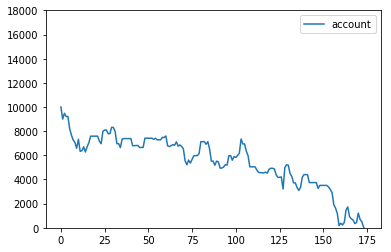

In [509]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account_long[['account']].plot()
ax1.set_ylim(0,18000)